In [138]:
from __future__ import annotations

from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter, Namespace

from bonelab.util.echo_arguments import echo_arguments
from bonelab.util.registration_util import check_inputs_exist, check_for_output_overwrite, message_s

import numpy as np
import SimpleITK as sitk
import os
import yaml

from skimage.morphology import binary_dilation, binary_erosion, binary_closing, ball
from skimage.measure import label as sklabel
from skimage.filters import gaussian, median

from matplotlib import pyplot as plt

In [139]:

def expand_array_to_3d(array: np.ndarray, dim: int) -> np.ndarray:
    if dim == 0:
        return array[:, None, None]
    elif dim == 1:
        return array[None, :, None]
    elif dim == 2:
        return array[None, None, :]
    else:
        raise ValueError("`dim` must be 0, 1, or 2")


def create_efficient_3d_binary_operation(func: callable) -> callable:
    def efficient_3d_binary_operation(mask: np.ndarray, radius: int) -> np.ndarray:
        for dim in [0, 1, 2]:
            mask = func(mask, expand_array_to_3d(np.ones((2 * radius + 1,)), dim))
        return mask
    return efficient_3d_binary_operation


def efficient_3d_dilation(mask: np.ndarray, radius: int) -> np.ndarray:
    return create_efficient_3d_binary_operation(binary_dilation)(mask, radius)


def efficient_3d_erosion(mask: np.ndarray, radius: int) -> np.ndarray:
    return create_efficient_3d_binary_operation(binary_erosion)(mask, radius)


def efficient_3d_closing(mask: np.ndarray, radius: int) -> np.ndarray:
    return efficient_3d_dilation(efficient_3d_erosion(mask, radius), radius)


def efficient_3d_opening(mask: np.ndarray, radius: int) -> np.ndarray:
    return efficient_3d_erosion(efficient_3d_dilation(mask, radius), radius)


def keep_largest_connected_component_skimage(mask: np.ndarray, background: bool = False) -> np.ndarray:
    if not(isinstance(mask, np.ndarray)):
        raise ValueError("`mask` must be a 3D numpy array")
    mask = (1 - mask) if background else mask
    labelled_mask = sklabel(mask, background=0)
    component_counts = np.bincount(labelled_mask.flat)
    if len(component_counts) < 2:
        return mask
    mask = labelled_mask == np.argmax(component_counts[1:]) + 1
    mask = ~mask if background else mask
    return mask.astype(int)


def remove_islands_from_mask(mask: np.ndarray, erosion_dilation: int = 1) -> np.ndarray:
    if not(isinstance(erosion_dilation, int)) or (erosion_dilation < 0):
        raise ValueError("`erosion_dilation` must be a positive integer")
    if not(isinstance(mask, np.ndarray)) or (len(mask.shape) != 3):
        raise ValueError("`mask` must be a 3D numpy array")
    mask = np.pad(mask, ((1, 1), (1, 1), (1, 1)), mode='constant')
    if erosion_dilation > 0:
        mask = efficient_3d_erosion(mask, erosion_dilation)
    mask = keep_largest_connected_component_skimage(mask.astype(int), background=False)
    if erosion_dilation > 0:
        mask = efficient_3d_dilation(mask, erosion_dilation)
    return mask[1:-1, 1:-1, 1:-1].astype(int)


def fill_in_gaps_in_mask(mask: np.ndarray, dilation_erosion: int = 1) -> np.ndarray:
    if not(isinstance(dilation_erosion, int)) or (dilation_erosion < 0):
        raise ValueError("`dilation_erosion` must be a positive integer")
    if not(isinstance(mask, np.ndarray)) or (len(mask.shape) != 3):
        raise ValueError("`mask` must be a 3D numpy array")
    pad_width = 2 * dilation_erosion if (dilation_erosion > 0) else None
    if pad_width:
        pad_width = 2 * dilation_erosion
        mask = np.pad(mask, ((pad_width, pad_width), (pad_width, pad_width), (pad_width, pad_width)), mode='constant')
    if dilation_erosion > 0:
        mask = efficient_3d_dilation(mask, dilation_erosion)
    mask = keep_largest_connected_component_skimage(mask.astype(int), background=True)
    if dilation_erosion > 0:
        mask = efficient_3d_erosion(mask, dilation_erosion)
    if pad_width:
        mask = mask[pad_width:-pad_width, pad_width:-pad_width, pad_width:-pad_width]
    return keep_largest_connected_component_skimage(mask.astype(int), background=True)


def iterative_filter(mask: np.ndarray, n_islands: int, n_gaps: int) -> np.ndarray:
    if not(isinstance(mask, np.ndarray)) or (len(mask.shape) != 3):
        raise ValueError("`mask` must be a 3D numpy array")
    if not(isinstance(n_islands, int)) or (n_islands < 0):
        raise ValueError("`n_islands` must be a positive integer")
    if not(isinstance(n_gaps, int)) or (n_gaps < 0):
        raise ValueError("`n_gaps` must be a positive integer")
    for n in range(1, min(n_islands, n_gaps) + 1):
        mask = remove_islands_from_mask(mask, erosion_dilation=n)
        mask = fill_in_gaps_in_mask(mask, dilation_erosion=n)
    if n_islands > n_gaps:
        mask = remove_islands_from_mask(mask, erosion_dilation=n_islands)
    elif n_gaps > n_islands:
        mask = fill_in_gaps_in_mask(mask, dilation_erosion=n_gaps)
    return mask


def dilate_and_subtract(mask: np.ndarray, thickness: int) -> np.ndarray:
    if not(isinstance(mask, np.ndarray)) or (len(mask.shape) != 3):
        raise ValueError("`mask` must be a 3D numpy array")
    if not(isinstance(thickness, int)) or (thickness < 0):
        raise ValueError("`thickness` must be a positive integer")
    dilated_mask = efficient_3d_dilation(mask, thickness)
    return (dilated_mask & (~mask)).astype(int)


def erode_and_subtract(mask: np.ndarray, thickness: int) -> np.ndarray:
    if not(isinstance(mask, np.ndarray)) or (len(mask.shape) != 3):
        raise ValueError("`mask` must be a 3D numpy array")
    if not(isinstance(thickness, int)) or (thickness < 0):
        raise ValueError("`thickness` must be a positive integer")
    eroded_mask = efficient_3d_erosion(mask, thickness)
    return ((~eroded_mask) & mask).astype(int)


def postprocess_model_masks(
        subchondral_bone_plate_mask: np.ndarray,
        trabecular_bone_mask: np.ndarray,
        min_subchondral_bone_plate_thickness: int = 4,
        bone_fill_gaps_radius: int = 5,
        bone_remove_islands_radius: int = 4,
        trab_fill_gaps_radius: int = 5,
        silent: bool = False
) -> np.ndarray:
    message_s("", silent)
    message_s(f"B <- Tb ∪ Sc", silent)
    bone_mask = trabecular_bone_mask | subchondral_bone_plate_mask
    message_s(f"B <- fill_gaps(B | r={bone_fill_gaps_radius})", silent)
    bone_mask = fill_in_gaps_in_mask(bone_mask, dilation_erosion=bone_fill_gaps_radius)
    message_s(f"B <- remove_islands(B | r={bone_remove_islands_radius})", silent)
    bone_mask = remove_islands_from_mask(bone_mask, erosion_dilation=bone_remove_islands_radius)
    message_s(f"Sc <- Sc ∪ (B ∩ (¬ erode(B | r={min_subchondral_bone_plate_thickness})))", silent)
    subchondral_bone_plate_mask = (
            subchondral_bone_plate_mask
            | erode_and_subtract(bone_mask, min_subchondral_bone_plate_thickness)
    )
    message_s(f"Sc <- remove_islands(Sc | r=0)", silent)
    subchondral_bone_plate_mask = remove_islands_from_mask(subchondral_bone_plate_mask, 0)
    message_s(f"Tb <- B ∩ (¬ Sc)", silent)
    trabecular_bone_mask = bone_mask & (~subchondral_bone_plate_mask)
    message_s(
        f"Tb <- Tb ∪ (erode(fill_gaps(dilate(Tb | r={trab_fill_gaps_radius}) | r=0) | r={2*trab_fill_gaps_radius}))",
        silent
    )
    trabecular_bone_mask = (
        trabecular_bone_mask
        | efficient_3d_erosion(
            fill_in_gaps_in_mask(
                efficient_3d_dilation(
                    trabecular_bone_mask,
                    trab_fill_gaps_radius
                ),
                dilation_erosion=0
            ),
            2 * trab_fill_gaps_radius
        )
    )
    message_s(f"Sc <- Sc ∩ (¬ Tb)", silent)
    subchondral_bone_plate_mask = subchondral_bone_plate_mask & (~trabecular_bone_mask)
    return subchondral_bone_plate_mask.astype(int), trabecular_bone_mask.astype(int)


def keep_smaller_components(mask: np.ndarray) -> np.ndarray:
    return np.logical_and(mask, np.logical_not(keep_largest_connected_component_skimage(mask, background=False)))


def slice_wise_keep_smaller_components(mask: np.ndarray, dims: List[int], pad_amount: int = 5) -> np.ndarray:
    mask = np.pad(
        mask,
        ((pad_amount, pad_amount), (pad_amount, pad_amount), (pad_amount, pad_amount)),
        mode='constant',
        constant_values=1
    )
    out = np.zeros_like(mask)
    for dim in dims:
        for i in range(mask.shape[dim]):
            st = tuple([slice(None) if j != dim else i for j in range(len(mask.shape))])
            out[st] = np.logical_or(out[st], keep_smaller_components(mask[st]))
    return out[pad_amount:-pad_amount, pad_amount:-pad_amount, pad_amount:-pad_amount]


def segment_tunnel(
        cortical_mask: np.ndarray,
        trabecular_mask: np.ndarray,
        tunnel_min_size: int = 0,
        silent: bool = False
) -> np.ndarray:
    message_s("", silent)
    message_s(f"Step 1: B <- ¬(Sc ∪ Tb)", silent)
    background_mask = np.logical_not(np.logical_or(cortical_mask, trabecular_mask))
    message_s(f"Step 2: T <- slice_wise_keep_smaller_components(B)", silent)
    tunnel_mask = slice_wise_keep_smaller_components(background_mask, dims=[0, 1, 2])  # hard code to use all dimensions
    message_s(f"Step 3: T <- keep_largest_connected_component(T)", silent)
    tunnel_mask = keep_largest_connected_component_skimage(tunnel_mask, background=False)
    message_s(f"Step 4: Check that |T| > {tunnel_min_size}", silent)
    if np.sum(tunnel_mask) < tunnel_min_size:
        message_s(f"|T| < {tunnel_min_size} => No tunnel detected", silent)
        return np.zeros_like(tunnel_mask).astype(int)
    else:
        message_s(f"|T| >= {tunnel_min_size} => Tunnel detected", silent)
        return tunnel_mask.astype(int)

In [140]:
image = sitk.ReadImage(
    "/Users/nathanneeteson/Documents/Data/Images/TRIKNEE/"
    "niftis/triknee_15_tl_1.nii.gz"
)

mask = sitk.ReadImage(
    "/Users/nathanneeteson/Documents/Data/Images/TRIKNEE/"
    "model_masks/triknee_15_tl_1_ensemble_inference_mask.nii.gz"
)

image = sitk.GetArrayFromImage(image)
mask = sitk.GetArrayFromImage(mask)

In [141]:
print(image.shape)

(504, 1308, 1508)


In [142]:
cort = (mask == 0)
trab = (mask == 1)

0


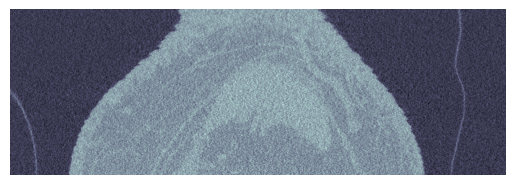

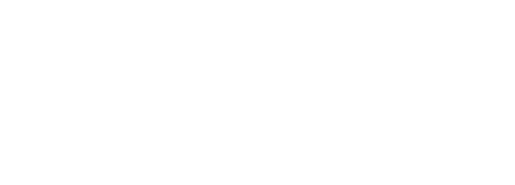

100


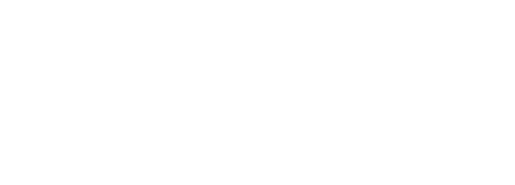

200


300


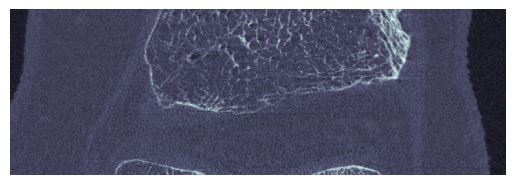

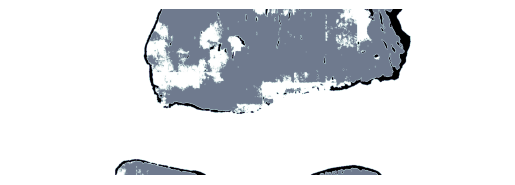

400


500


600


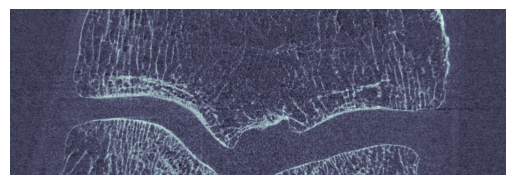

700


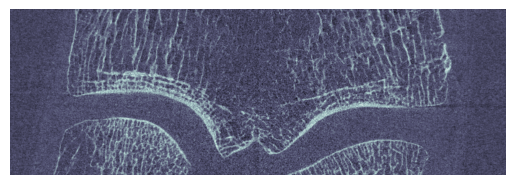

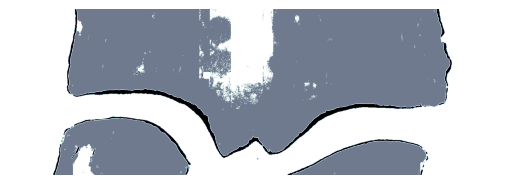

800


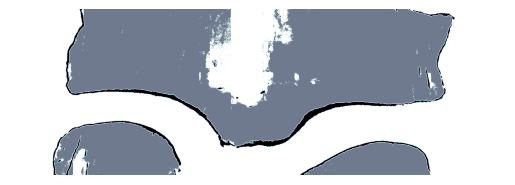

900


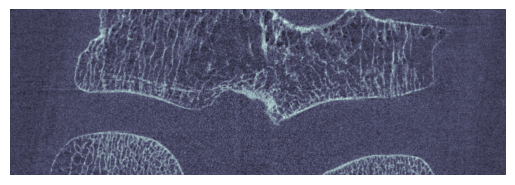

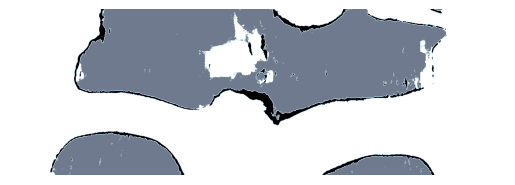

1000


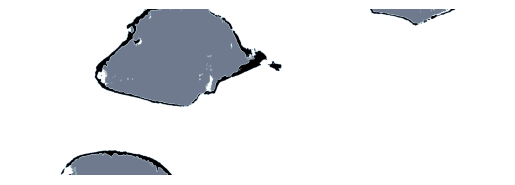

1100


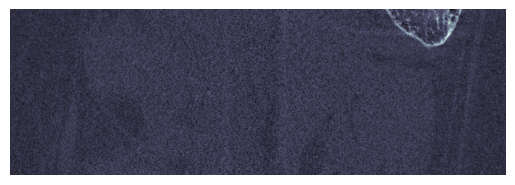

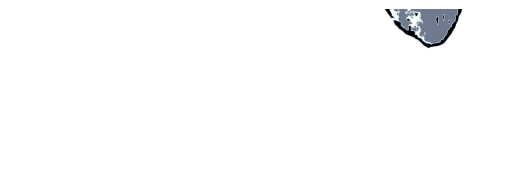

In [143]:
for i in range(0,1200,100):

    print(i)
    fig = plt.figure()

    plt.imshow(image[:,i,:], cmap="bone")

    plt.axis(False)

    plt.show()


    fig = plt.figure()

    plt.imshow(cort[:,i,:], vmin=0, vmax=1, cmap="bone_r")
    plt.imshow(trab[:,i,:], vmin=0, vmax=2, cmap="bone_r", alpha=1.0*trab[:,i,:])

    plt.axis(False)

    plt.show()

In [144]:
st = (slice(None), slice(700,900), slice(None))

image_sub = image[st]
cort_sub = cort[st]
trab_sub = trab[st]

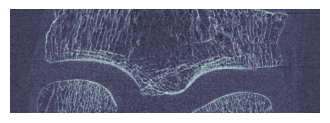

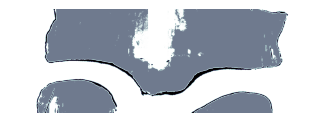

In [145]:
i = 100

fig = plt.figure(figsize=(4,4))

plt.imshow(image_sub[:,i,:], cmap="bone")

plt.axis(False)

plt.savefig("post-proc-0_image.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()


fig = plt.figure(figsize=(4,4))

plt.imshow(cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")
plt.imshow(trab_sub[:,i,:], vmin=0, vmax=2, cmap="bone_r", alpha=1.0*trab_sub[:,i,:])

plt.axis(False)

plt.savefig("post-proc-1_inference_masks.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [146]:
bone_sub = cort_sub | trab_sub

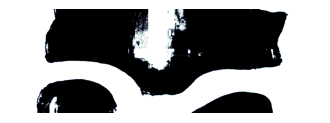

In [147]:
fig = plt.figure(figsize=(4,4))

plt.imshow(bone_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-2_bone_mask.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [148]:
bone_sub = fill_in_gaps_in_mask(bone_sub, dilation_erosion=5)

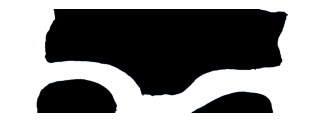

In [149]:
fig = plt.figure(figsize=(4,4))

plt.imshow(bone_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-3_bone_mask_filled.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [150]:
bone_sub = remove_islands_from_mask(bone_sub, erosion_dilation=4)

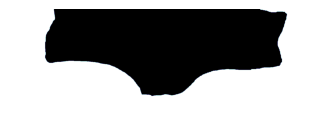

In [151]:
fig = plt.figure(figsize=(4,4))

plt.imshow(bone_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-4_bone_mask_no_islands.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [152]:
cort_sub = (
    cort_sub
    | erode_and_subtract(bone_sub, 4)
)

In [153]:
fig = plt.figure(figsize=(4,4))

plt.imshow(cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-5_min_cort.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [154]:
cort_sub = remove_islands_from_mask(cort_sub, 0)

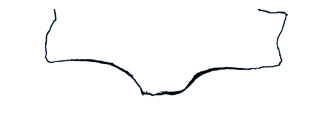

In [155]:
fig = plt.figure(figsize=(4,4))

plt.imshow(cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-6_cort_no_islands.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [156]:
trab_sub = bone_sub & (~cort_sub)

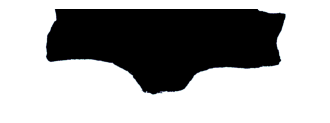

In [157]:
fig = plt.figure(figsize=(4,4))

plt.imshow(trab_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-7_new_trab.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [158]:
trab_sub = (
    trab_sub
    | efficient_3d_erosion(
        fill_in_gaps_in_mask(
            efficient_3d_dilation(
                trab_sub,
                5
            ),
            0
        ),
        10
    )
)

In [159]:
fig = plt.figure(figsize=(4,4))

plt.imshow(trab_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-8_trab_filt.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [160]:
cort_sub = cort_sub & (~trab_sub)

In [161]:
fig = plt.figure(figsize=(4,4))

plt.imshow(cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("post-proc-9_cort_filt.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

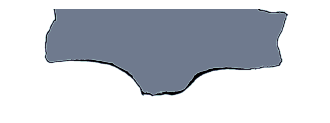

In [162]:
fig = plt.figure(figsize=(4,4))

plt.imshow(cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")
plt.imshow(trab_sub[:,i,:], vmin=0, vmax=2, cmap="bone_r", alpha=1.0*trab_sub[:,i,:])

plt.axis(False)

plt.savefig("post-proc-10_postprocessed_masks.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [163]:
tunnel_image = sitk.ReadImage(
    "/Users/nathanneeteson/Documents/Data/Images/CONMED/"
    "niftis/conmd02r_t.nii.gz"
)

tunnel_mask = sitk.ReadImage(
    "/Users/nathanneeteson/Documents/Data/Images/CONMED/"
    "model_masks/conmd02r_t_postprocessed_mask.nii.gz"
)

tunnel_image = sitk.GetArrayFromImage(tunnel_image)
tunnel_mask = sitk.GetArrayFromImage(tunnel_mask)

In [164]:
tunnel_cort = (tunnel_mask == 1)
tunnel_trab = (tunnel_mask == 2)

0


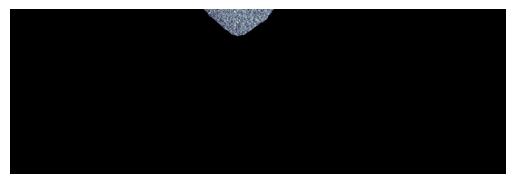

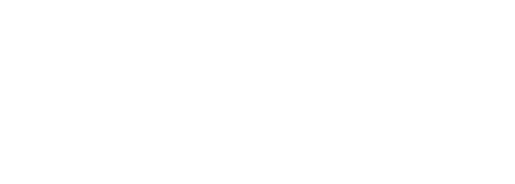

100


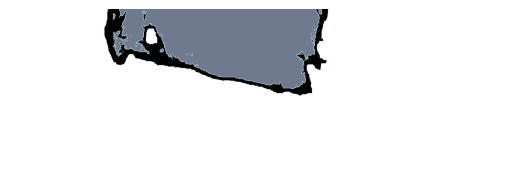

200


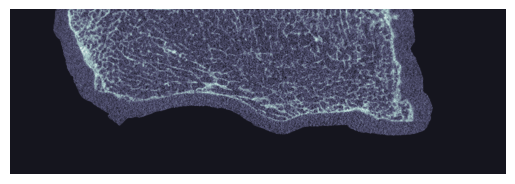

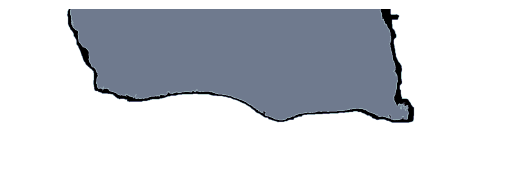

300


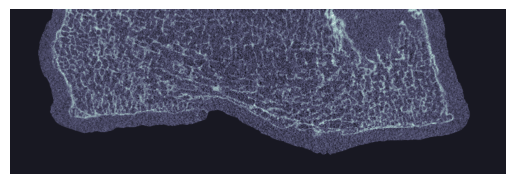

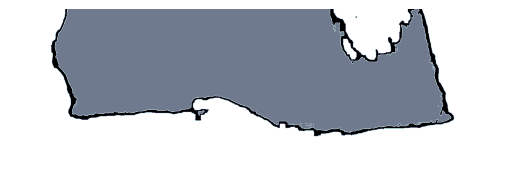

400


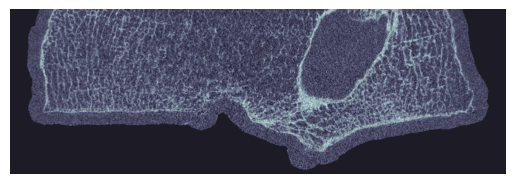

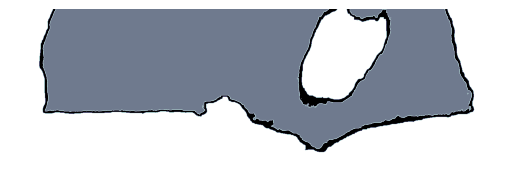

500


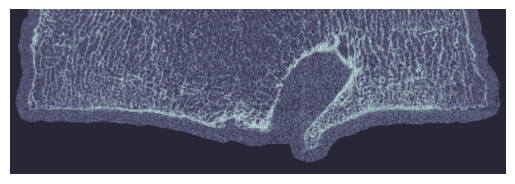

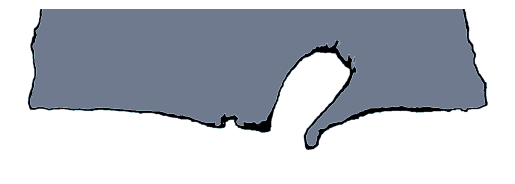

600


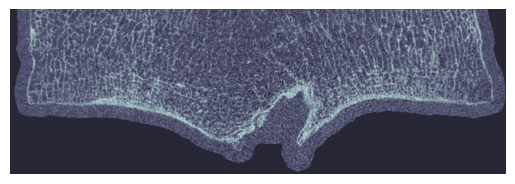

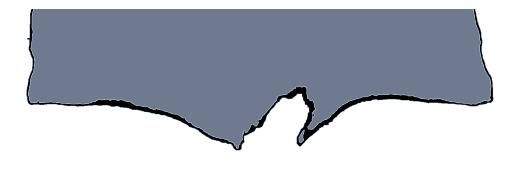

700


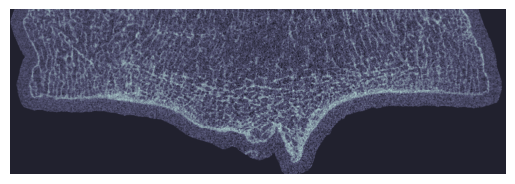

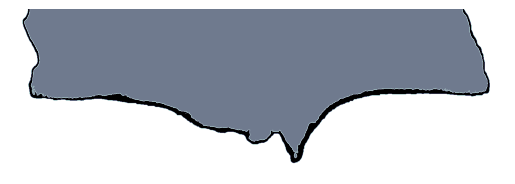

800


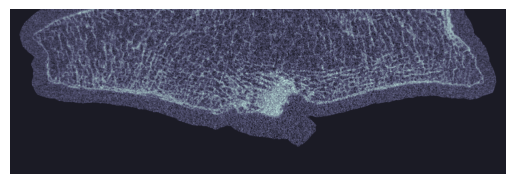

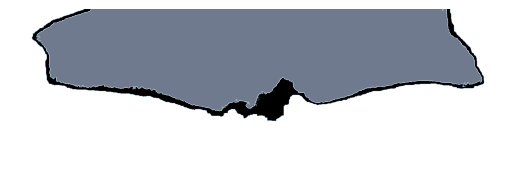

900


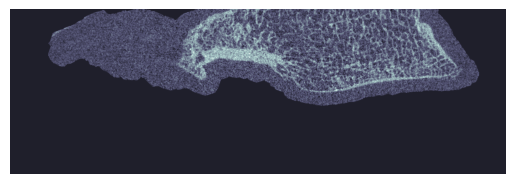

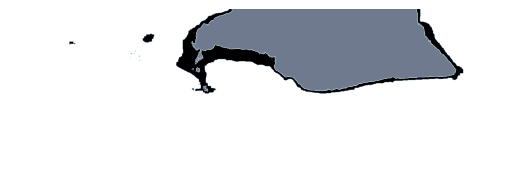

1000


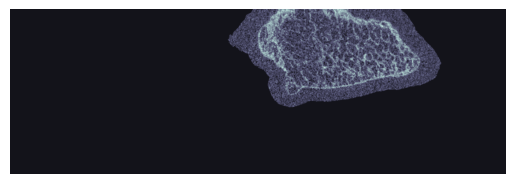

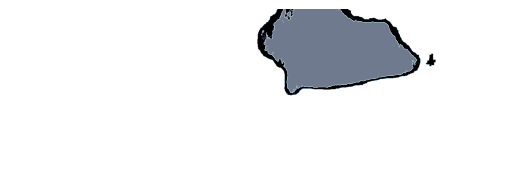

1100


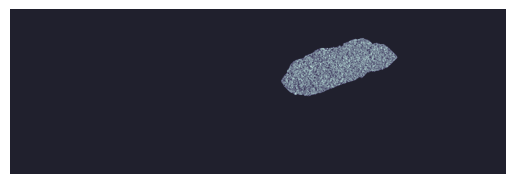

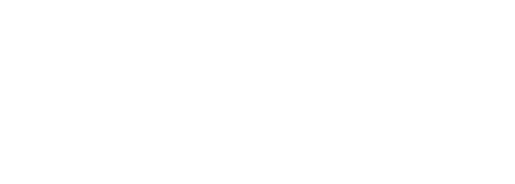

In [165]:
for i in range(0,1200,100):

    print(i)
    fig = plt.figure()

    plt.imshow(tunnel_image[:,i,:], cmap="bone")

    plt.axis(False)

    plt.show()


    fig = plt.figure()

    plt.imshow(tunnel_cort[:,i,:], vmin=0, vmax=1, cmap="bone_r")
    plt.imshow(tunnel_trab[:,i,:], vmin=0, vmax=2, cmap="bone_r", alpha=1.0*tunnel_trab[:,i,:])

    plt.axis(False)

    plt.show()

In [166]:
st = (slice(None), slice(300,500), slice(None))

tunnel_image_sub = tunnel_image[st]
tunnel_cort_sub = tunnel_cort[st]
tunnel_trab_sub = tunnel_trab[st]

In [167]:
i = 120

fig = plt.figure(figsize=(4,4))

plt.imshow(tunnel_image_sub[:,i,:], cmap="bone")

plt.axis(False)

plt.savefig("tunnel-0_image.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()


fig = plt.figure(figsize=(4,4))

plt.imshow(tunnel_cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")
plt.imshow(tunnel_trab_sub[:,i,:], vmin=0, vmax=2, cmap="bone_r", alpha=1.0*tunnel_trab_sub[:,i,:])

plt.axis(False)

plt.savefig("tunnel-1_postproc_masks.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [168]:
def segment_tunnel(
        cortical_mask: np.ndarray,
        trabecular_mask: np.ndarray,
        tunnel_min_size: int = 0,
        silent: bool = False
) -> np.ndarray:
    message_s("", silent)
    message_s(f"Step 1: B <- ¬(Sc ∪ Tb)", silent)
    background_mask = np.logical_not(np.logical_or(cortical_mask, trabecular_mask))
    message_s(f"Step 2: T <- slice_wise_keep_smaller_components(B)", silent)
    tunnel_mask = slice_wise_keep_smaller_components(background_mask, dims=[0, 1, 2])  # hard code to use all dimensions
    message_s(f"Step 3: T <- keep_largest_connected_component(T)", silent)
    tunnel_mask = keep_largest_connected_component_skimage(tunnel_mask, background=False)
    message_s(f"Step 4: Check that |T| > {tunnel_min_size}", silent)
    if np.sum(tunnel_mask) < tunnel_min_size:
        message_s(f"|T| < {tunnel_min_size} => No tunnel detected", silent)
        return np.zeros_like(tunnel_mask).astype(int)
    else:
        message_s(f"|T| >= {tunnel_min_size} => Tunnel detected", silent)
        return tunnel_mask.astype(int)

In [169]:
tunnel_background_sub = ~(tunnel_cort_sub | tunnel_trab_sub)

In [170]:
fig = plt.figure(figsize=(4,4))

plt.imshow(tunnel_background_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("tunnel-2_background.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [171]:
tunnel_sub = slice_wise_keep_smaller_components(tunnel_background_sub.astype(int), dims=[0, 1, 2])

In [172]:
fig = plt.figure(figsize=(4,4))

plt.imshow(tunnel_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("tunnel-2_tunnel.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [173]:
tunnel_sub = keep_largest_connected_component_skimage(tunnel_sub, background=False)

In [174]:
fig = plt.figure(figsize=(4,4))

plt.imshow(tunnel_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")

plt.axis(False)

plt.savefig("tunnel-3_tunnel_largest.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

In [175]:
np.sum(tunnel_sub)

1737608

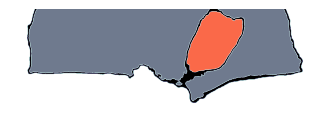

In [176]:
fig = plt.figure(figsize=(4,4))

plt.imshow(tunnel_cort_sub[:,i,:], vmin=0, vmax=1, cmap="bone_r")
plt.imshow(tunnel_trab_sub[:,i,:], vmin=0, vmax=2, cmap="bone_r", alpha=1.0*tunnel_trab_sub[:,i,:])
plt.imshow(tunnel_sub[:,i,:], vmin=0, vmax=2, cmap="Reds", alpha=1.0*tunnel_sub[:,i,:])

plt.axis(False)

plt.savefig("tunnel-4_final.png", dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()